# Date Fruit Dataset - Analysis and Model Training
This dataset comes from a paper (reference below) which extracted features from 898 images of 7 different Date species in an effort ot classify them using Logistic Regression and Artificial Neural Networks, which yielded classification accuracies of 91.0% and 92.2%, respectively. Stacking the models yielded a slight increase in accuracy (92.8%).

The authors don't mention any feature selection strategies or attempts to further improve their models. Since feature selection, feature transformation, model selection, and hyperparameter tuning can optimize performance, I am curious to see if better accuracies can be achieved on this dataset.

KOKLU, M., KURSUN, R., TASPINAR, Y. S., and CINAR, I. (2021). Classification of Date Fruits into Genetic Varieties Using Image Analysis. Mathematical Problems in Engineering, Vol.2021, Article ID: 4793293, DOI:10.1155/2021/4793293
https://www.hindawi.com/journals/mpe/2021/4793293/
DATASET: https://www.muratkoklu.com/datasets/
https://www.kaggle.com/mkoklu42

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sa
import statsmodels.formula.api as sfa
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler

df = pd.read_excel("Date_Fruit_Datasets/raw_dataset.xlsx")
df.rename(columns={'Class':'Species'}, inplace=True)
df.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB,Species
0,422163,2378.908,837.8484,645.6693,0.6373,733.1539,0.9947,424428,0.7831,1.2976,...,3.2370,2.9574,4.2287,-59191263232,-50714214400,-39922372608,58.7255,54.9554,47.8400,BERHI
1,338136,2085.144,723.8198,595.2073,0.5690,656.1464,0.9974,339014,0.7795,1.2161,...,2.6228,2.6350,3.1704,-34233065472,-37462601728,-31477794816,50.0259,52.8168,47.8315,BERHI
2,526843,2647.394,940.7379,715.3638,0.6494,819.0222,0.9962,528876,0.7657,1.3150,...,3.7516,3.8611,4.7192,-93948354560,-74738221056,-60311207936,65.4772,59.2860,51.9378,BERHI
3,416063,2351.210,827.9804,645.2988,0.6266,727.8378,0.9948,418255,0.7759,1.2831,...,5.0401,8.6136,8.2618,-32074307584,-32060925952,-29575010304,43.3900,44.1259,41.1882,BERHI
4,347562,2160.354,763.9877,582.8359,0.6465,665.2291,0.9908,350797,0.7569,1.3108,...,2.7016,2.9761,4.4146,-39980974080,-35980042240,-25593278464,52.7743,50.9080,42.6666,BERHI


## Exploratory Data Analysis - Feature Selection
Before making any predictions, we need to explore the data and look for patterns which will us predict the Date species

In [3]:
X = df.iloc[:, :-1]
nclasses = df["Species"].nunique()
nfeatures = len(X.columns)

print(f"{nclasses} Species, {nfeatures} features")
print(df["Species"].value_counts())

7 Species, 34 features
DOKOL     204
SAFAVI    199
ROTANA    166
DEGLET     98
SOGAY      94
IRAQI      72
BERHI      65
Name: Species, dtype: int64


Two things jump out with this quick summary:
1. The dataset is imbalanced
2. There are at least 2 observations per feature per class, far fewer than the desired value of 10

Taking these observations into account will help us better train our models.

In [4]:
sig_features = []

for col in X.columns:
    lm = sfa.ols(f"{col} ~ C(Species)", data=df).fit()
    anova = sa.stats.anova_lm(lm)
    pval = anova["PR(>F)"]["C(Species)"]
    if pval < 1e-10:
        sig_features.append(col)
        
print(len(sig_features))

32


Using ANOVA helped us remove two variables which were not different at all between the species. Since all features came from images of Dates taken under similar conditions, it is quite likely that some features are correlated with each other.

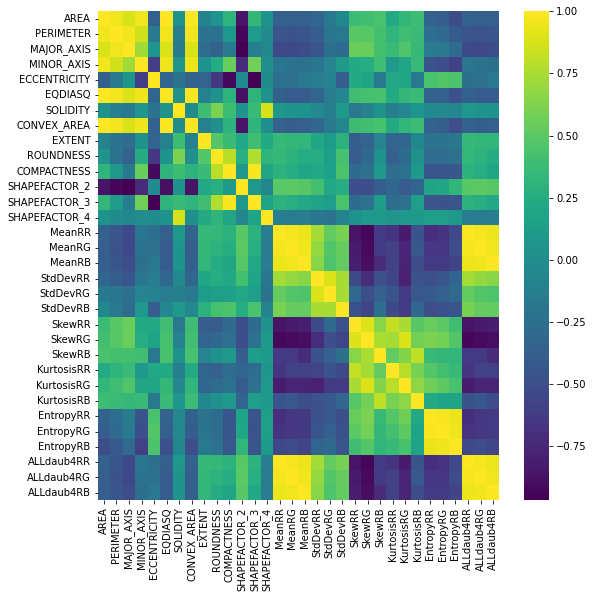

In [10]:
X = df[sig_features]
plt.figure(figsize=(9, 9))
ax = sns.heatmap(X.corr(), cmap="viridis")

Areas of blue and red indicate high correlation and represent features we may wish to drop. Let's remove columns with shared correlation greater than 0.7 and see how many features remain.

In [11]:
print(X.shape)
corr = X.corr()
for col in X.columns:
    corrs = np.abs(corr[col])
    corr_cols = np.sum(corrs > 0.7)
    # has to be greater than 1 since the column itself is included
    if corr_cols > 1:
        X.drop(columns=[col], inplace=True)
    corr = X.corr()
print(X.shape)

(898, 32)
(898, 8)


Excellent! We've now gone from 32 down to 8 features which have far lower correlation. Let's have a quick peak at the correlation heatmap to see how it looks

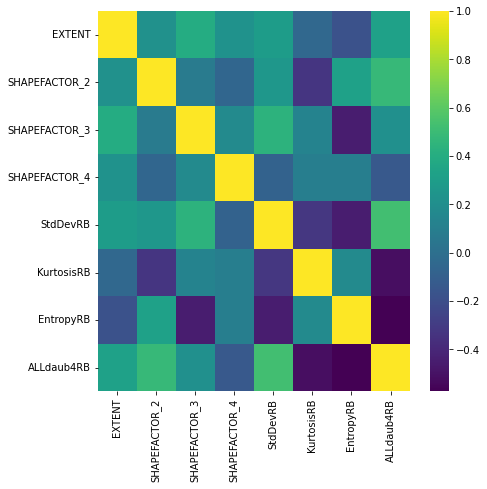

In [12]:
plt.figure(figsize=(7, 7))
ax = sns.heatmap(X.corr(), cmap="viridis")

In [13]:
# Save the reduced features dataset for later training
data = pd.concat([X, Y], axis=1)
data.to_excel("Date_Fruit_Datasets/reduced_features_dataset.xlsx", index=False)

NameError: name 'Y' is not defined

## Exploratory Data Analysis - Transformation
Linear models such as Logistic Regression can be impacted by features with drastically different ranges. To compensate for this, we can apply mathematical transformations to compress or transform our features into specific ranges. To see if this is necessary, let's look at the ranges of each feature

In [8]:
X.describe()

,EXTENT,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4,StdDevRB,KurtosisRB,EntropyRB,ALLdaub4RB
count,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,8.980000e+02,898.000000
mean,0.736267,0.001794,0.655420,0.988680,26.148330,3.780928,-2.771876e+10,48.098393
std,0.053745,0.000428,0.094314,0.020473,4.905078,2.049831,1.484137e+10,10.813862
min,0.512300,0.001100,0.001700,0.756800,5.148600,1.767200,-8.747177e+10,22.130000
25%,0.705875,0.001500,0.589975,0.989300,22.890975,2.577275,-3.564534e+10,39.250725
50%,0.746950,0.001600,0.647950,0.993600,26.469000,3.080700,-2.392928e+10,49.614100
75%,0.775850,0.002075,0.720625,0.996400,29.482375,4.283125,-1.660367e+10,56.666675
max,0.856200,0.004300,0.937300,0.999500,42.422800,32.249500,-4.370435e+08,74.104600


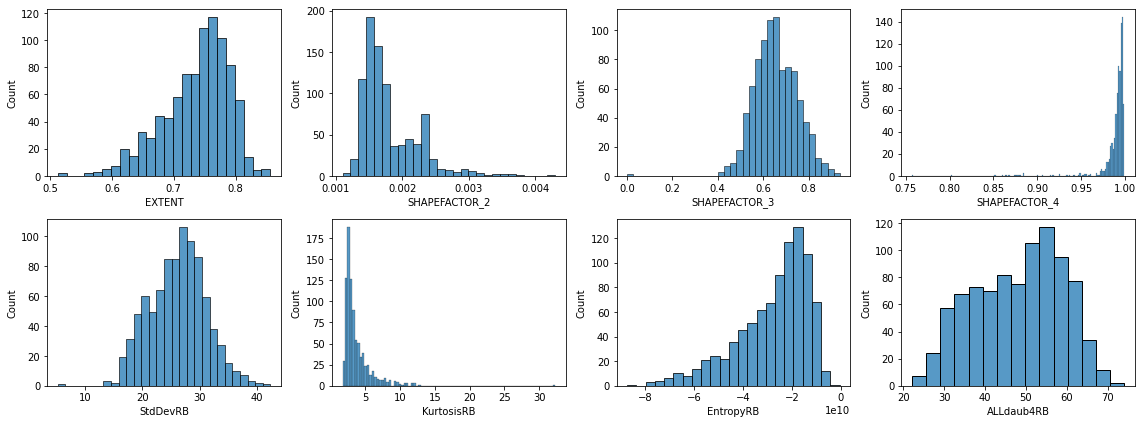

In [9]:
plt.figure(figsize=(16, 6))
for i, col in enumerate(X.columns, 1):
    plt.subplot(2, 4, i)
    sns.histplot(X[col])
plt.tight_layout()

These features have drastically different ranges and some will need to be transformed to remove the skew in their distributions.

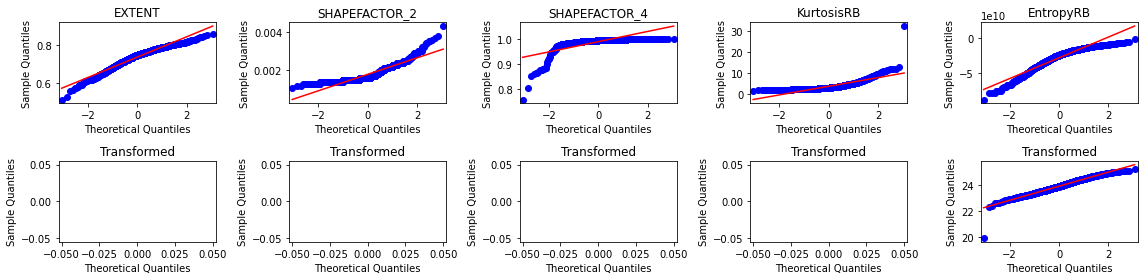

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(16, 4))
for i,col in enumerate(["EXTENT", "SHAPEFACTOR_2", "SHAPEFACTOR_4", "KurtosisRB", "EntropyRB"]):
    # edit this line to observe effects of different transformations
    transformed = np.log(X[col] * -1)
    
    qqplot(X[col], line="s", ax=axes[0, i])
    axes[0, i].set_title(col)
    qqplot(transformed, line="s", ax=axes[1, i])
    axes[1, i].set_title("Transformed")
    plt.tight_layout()

Playing around with these graphs, we see that the data become normal with the following transformations:
* $ EXTENT^{3} $
* $ \frac{1}{SHAPEFACTOR_2} $
* $ \frac{1}{KurtosisRB} $
* $ ln(EntropyRB^{2}) $

Attempts to transform SHAPEFACTOR_4 were unsuccessful since the majority of the values are close to 1. It may also be the case that the values far from 1 belong to a specific class, thus their deviation from 1 may be important for predicting classes.

In [11]:
X["EXTENT_transformed"] = X["EXTENT"] ** 3
X["SHAPEFACTOR_2_transformed"] = 1 / X["SHAPEFACTOR_2"]
X["KurtosisRB_transformed"] = 1 / X["KurtosisRB"]
X["EntropyRB_transformed"] = np.log(X["EntropyRB"] * -1)

Now that the variables have been transformed to better approximate a normal distribution, we can scale the data to the same range and save it for training.

In [12]:
transform_cols = ["EXTENT_transformed", "SHAPEFACTOR_2_transformed", "SHAPEFACTOR_3",
                  "SHAPEFACTOR_4", "StdDevRB", "KurtosisRB_transformed",
                  "EntropyRB_transformed", "ALLdaub4RB"]
scaler = StandardScaler()
scaled = scaler.fit_transform(X[transform_cols])
transformed = pd.DataFrame(scaled, columns=transform_cols)
transformed["Species"] = df["Species"]
transformed.to_excel("Date_Fruit_Datasets/scaled_reduced_dataset.xlsx", index=False)